In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
from math import pi

def norm_sq_of_wf_on_uniform_grid_polar_box(wf, dr):
    _wf_abs_sq = np.real(wf.conj() * wf)
    return 2.* pi * dr * np.sum(_wf_abs_sq)

def normalize_wf_on_uniform_grid_polar_box(wf, dr):
    _norm_sq = norm_sq_of_wf_on_uniform_grid_polar_box(wf, dr)
    wf *= 1. / np.sqrt(_norm_sq)

from tdse.evol import get_M2_tridiag, get_D2_tridiag, mul_tridiag_and_diag
from tdse.tridiag import tridiag_forward, tridiag_backward

class Propagator_on_Uniform_Grid_Polar_Box(object):
    """Propagator object defined on a polar box with uniform grid"""
    
    def __init__(self, Nr, dr, m_max, Vr=0.0, hbar=1.0, mass=1.0):
        """Initialize
        
        Parameters
        ----------
        Nr : int
            the number of radial grid points
        dr : float
            the radial grid spacing
        m_max : int
            maximum azimuthal quantum number 'm'
        Vr : (Nr,) array-like
            radially symmetric potential values
            
        Notes
        -----
        The total wavefunction is expanded as:
        
        .. math::
        
            \\psi(r,\\phi,t) = 
            \\frac{1}{\\sqrt{r}}\\sum_{m=-m_{max}}^{m_{max}}
            {g_{m}(r,t)e^{im\\phi}}
        """
        
        # Check argumetns
        if Nr != int(Nr) or not (Nr > 0):
            _msg = "`Nr` should be a positive integer. Given: {}"
            raise ValueError(_msg.format(Nr))
        self.Nr = int(Nr)
        
        if not (float(dr) > 0):
            _msg = "`dr` should be positive real number. Given: {}"
            raise ValueError(_msg.format(dr))
        self.dr = float(dr)
        
        if m_max != int(m_max) or m_max < 0:
            _msg = "`m_max` should be nonnegative integer. Given: {}"
            raise ValueError(_msg.format(m_max))
        self.m_max = int(m_max)
        
        self.Nm = 2 * self.m_max + 1
        
        if Vr == 0.0: self.Vr = np.zeros((self.Nr,), dtype=np.float)
        else:
            _Vr = np.asarray(Vr)
            if _Vr.shape != (self.Nr,):
                _msg = "`Vr` should be of shape ({},). Given shape: {}"
                raise ValueError(_msg.format(self.Nr, _Vr.shape))
            self.Vr = _Vr
        
        self.hbar, self.mass = hbar, mass
        
        
        # Evaluate matrices for constructing propagator
        self.r_arr = self.dr * np.arange(1, self.Nr+1)
        self.r_max = self.r_arr[-1] + dr
        self.M2 = get_M2_tridiag(self.Nr)
        
        self.M2Hm = np.empty((self.Nm, 3, self.Nr), dtype=np.complex)
        
#         _M2Hm_2d_shape = (3, self.Nm * self.Nr)
#         self.M2Hm_2d = np.empty(_M2Hm_2d_shape, dtype=np.complex)
        
        _D2 = get_D2_tridiag(self.Nr, self.dr)
        
        # correction to match boundary condition at r=0 (i.e. dr_gm = 0)
        _delta_dr_sq = -3.
        _D2[1,0] = _delta_dr_sq / self.dr**2
        self.M2[1,0] = (12 + _delta_dr_sq) / 12.0
        
        _hbar2m = - 0.5 * self.hbar**2 / self.mass
        _Kr = _hbar2m * _D2  # something like radial kinetic energy
        
        _r_sq_arr = np.square(self.r_arr)
        for _im, _m in enumerate(range(-self.m_max, self.m_max+1)):
            _Vm = self.Vr + (_hbar2m * (0.25-_m*_m)) / _r_sq_arr
            _M2Vm = mul_tridiag_and_diag(self.M2, _Vm)
            self.M2Hm[_im,:,:] = _Kr + _M2Vm
#             _start_index = im * self.Nm
#             self.M2Hm_2d[:,_start_index:_start_index+self.Nr] = _Kr + _M2Vm
    
            
    def propagate(self, wf, dt, Nt=1):
        """Propagate given wavefunction by a given timestep
        
        Parameters
        ----------
        wf : (Nm, Nr) or (Nm*Nr,) array-like
            array of wavefunction values
            where `Nm` is the number of azimuthal basis
            and `Nr` is the number of radial grid points
        dt : float
            timestep to propagate
        Nt : int
            number of timesteps
        """
        _wf_1d = np.ravel(wf)
        if _wf_1d.shape != (self.Nm * self.Nr,):
            _msg = ("Inconsistent wavefunction shape given: {}\n"
                    "It should be possible to flatten the shape into: {}")
            raise ValueError(_msg.format(_wf_1d.shape, (self.Nm * self.Nr,)))
        
        if Nt != int(Nt) or not (Nt > 0):
            _msg = "`Nt` should be a positive integer"
            raise ValueError(_msg.format(Nr))
        _Nt = int(Nt)
        
        _FO = (-0.5j*dt/self.hbar) * self.M2Hm
        _unitary_shape = (3,)+_wf_1d.shape
        _unitary_forward_half = np.swapaxes(self.M2+_FO, 0, 1).reshape(_unitary_shape)
        _unitary_backward_half = np.swapaxes(self.M2-_FO, 0, 1).reshape(_unitary_shape)
        
        _wf_1d_half = np.empty_like(_wf_1d, dtype=complex)
        for _it in range(_Nt):
            tridiag_forward(_unitary_forward_half, _wf_1d, _wf_1d_half)
            tridiag_backward(_unitary_backward_half, _wf_1d, _wf_1d_half)
            
            
    def propagate_to_ground_state(self, wf, dt=None, max_Nt=20000, Nt_per_iter=10, 
                                  norm_thres=1e-14):
        """Propagate the given wavefunction to the ground state of this system"""
        if dt is None: _dt = self.dr / 4.
        else:
            _dt = float(dt)
            if not (_dt > 0): 
                _msg = "`dt` should be a positive real number. Given: {}"
                raise ValueError(_msg.format(_dt))
        _imag_dt = -1.0j * _dt  # imaginary time for propagating to ground state
        
        normalize_wf_on_uniform_grid_polar_box(wf, self.dr)
        _wf_prev = wf.copy()
        
        _max_iter = int(max_Nt / Nt_per_iter) + 1
        for _i in range(_max_iter):
            self.propagate(wf, _imag_dt, Nt=Nt_per_iter)
            normalize_wf_on_uniform_grid_polar_box(wf, self.dr)
            _norm = norm_sq_of_wf_on_uniform_grid_polar_box(wf-_wf_prev, self.dr)
            if _norm < norm_thres: break
            _wf_prev = wf.copy()
        if _i >= _max_iter-1: raise Exception("Maximum iteration exceeded")
        else: print("iteration count at end: {}".format(_i))

In [58]:
prop = Propagator_on_Uniform_Grid_Polar_Box(Nr=101, dr=0.2, m_max=0, Vr=0.0)

In [48]:
-2 / prop.dr**2

-49.99999999999999

In [49]:
-2.2 / prop.dr**2

-54.99999999999999

In [50]:
D2 = get_D2_tridiag(prop.Nr, prop.dr)

In [51]:
D2[1,:]

array([-50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50., -50., -50., -50., -50., -50., -50., -50., -50., -50.,
       -50., -50.])

In [59]:
wf = np.empty((prop.Nm, prop.Nr), dtype=complex)
wf[:] = np.random.rand(prop.Nm, prop.Nr)

In [60]:
prop.propagate_to_ground_state(wf)

iteration count at end: 608


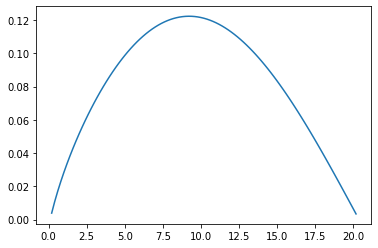

In [61]:
fig, ax = plt.subplots()
for im in range(prop.Nm):
    ax.plot(prop.r_arr, wf[im].real)

In [55]:
from scipy.special import jn, jn_zeros

j0_zero_0, = jn_zeros(0, 1)
j0_r = jn(0, j0_zero_0 * prop.r_arr / prop.r_max)
g0_r_ana = np.sqrt(prop.r_arr) * j0_r
normalize_wf_on_uniform_grid_polar_box(g0_r_ana, prop.dr)

g0_r_num = wf[0]

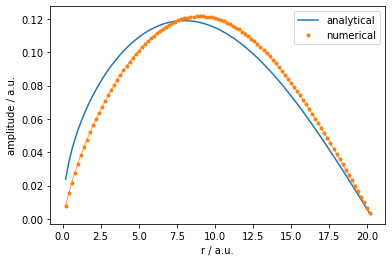

In [62]:
fig, ax = plt.subplots()
ax.plot(prop.r_arr, g0_r_ana, label='analytical')
lnum, = ax.plot(prop.r_arr, g0_r_num.real, '.', label='numerical')
ax.plot(prop.r_arr, np.abs(g0_r_num), color=lnum.get_color(), linewidth=0.7)
ax.set_xlabel("r / a.u."), ax.set_ylabel("amplitude / a.u.")
ax.legend()
# fig.savefig("propator-polar-box-test-1.png")

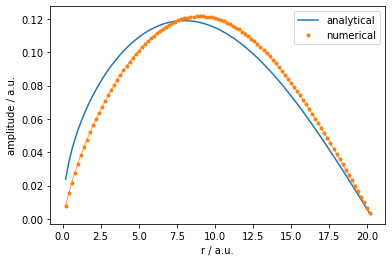

In [56]:
fig, ax = plt.subplots()
ax.plot(prop.r_arr, g0_r_ana, label='analytical')
lnum, = ax.plot(prop.r_arr, g0_r_num.real, '.', label='numerical')
ax.plot(prop.r_arr, np.abs(g0_r_num), color=lnum.get_color(), linewidth=0.7)
ax.set_xlabel("r / a.u."), ax.set_ylabel("amplitude / a.u.")
ax.legend()
# fig.savefig("propator-polar-box-test-1.png")

In [133]:
norm_sq_of_wf_on_uniform_grid_polar_box(wf, prop.dr)

1.0000000000000004

In [18]:
# fig.savefig("ground-state-prototype-test-1.png")

In [134]:
from tdse.matrix import mat_vec_mul_tridiag

In [135]:
mat_vec_mul_tridiag.__module__

'tdse.matrix_c'

In [15]:
aa = np.arange(120).reshape((3, 10, 4))

In [19]:
aa[:,0]

array([[ 0,  1,  2,  3],
       [40, 41, 42, 43],
       [80, 81, 82, 83]])

In [20]:
aa[:,1]

array([[ 4,  5,  6,  7],
       [44, 45, 46, 47],
       [84, 85, 86, 87]])

In [21]:
bb = aa.reshape((3, 40))

In [24]:
bb[:,:8]

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [80, 81, 82, 83, 84, 85, 86, 87]])